### What do I know so far
<li> Dual types do not care about order (grass/poison == poison/grass) </li>
<li> Effective types do double damage (from my friend who plays Pokemon) </li>
<li> People use BST and Average Stats traditionally to gauge pokemon strength </li>

### Things to consider for feature engineering
<li> Types </li>
<li> BST, indiv stats, or both </li>
<li> Future problems: Skills and immunities but I don't want to think about that right now </li>

In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm

In [2]:
combats = pd.read_csv("combats.csv")
pokemon = pd.read_csv("pokemon.csv")
tests = pd.read_csv("tests.csv")

In [3]:
pokemon['Type 2'].fillna("No Type", inplace=True)

In [4]:
pokemon.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,No Type,39,52,43,60,50,65,1,False


In [5]:
combats.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [6]:
pokemon['bst'] = pokemon['HP'] + pokemon['Attack'] + pokemon['Sp. Atk'] + pokemon['Defense'] + pokemon['Sp. Def'] + pokemon['Speed']   

In [7]:
import matplotlib.pyplot as plt
# Too lazy to make it look cleaner but the point is proven that legendaries have more base stats

plt.hist(pokemon[pokemon.Legendary].bst, alpha=0.5, label="Legendary")
plt.hist(pokemon[~pokemon.Legendary].bst, alpha=0.5, label="Not Legendary")
plt.legend()
plt.show()

<Figure size 640x480 with 1 Axes>

## Preprocessing 
To do: 
<li> Merge tables </li>
<li> Make prediction column (0 if first pokemon won, else 1) </li>
<li> Double attack, sp.atk, defense, sp.def if pokemon is effective against opponent </li>

In [8]:
#Drop Generation and Legendary Columns (useless as far as i'm concerned)
#Leave names somewhere
pokemon_names = pokemon[["#", "Name", "Generation", "Legendary"]]
pokemon.drop(["Name", "Generation", "Legendary"], axis=1, inplace=True)
pokemon_names.to_csv("pokemon_details.csv")

In [9]:
#Merge
pokemon1 = pokemon.add_prefix("first_")
pokemon2 = pokemon.add_prefix("second_")
train = pokemon1.merge(combats, left_on="first_#", right_on="First_pokemon", how="inner")
train = pokemon2.merge(train, left_on="second_#", right_on="Second_pokemon", how="inner")

In [10]:
#Prediction Column
#dumbass method

train['outcome'] = 0 
train.outcome.loc[train.Winner == train.Second_pokemon] = 1

C:\Users\tresyap\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
train.sample(1)

,second_#,second_Type 1,second_Type 2,second_HP,second_Attack,second_Defense,second_Sp. Atk,second_Sp. Def,second_Speed,second_bst,...,first_Attack,first_Defense,first_Sp. Atk,first_Sp. Def,first_Speed,first_bst,First_pokemon,Second_pokemon,Winner,outcome
8958,149,Normal,No Type,65,60,70,85,75,40,395,...,70,40,35,40,60,285,497,149,497,0


More or less balanced set

In [12]:
train.outcome.value_counts(normalize=True)

1    0.52798
0    0.47202
Name: outcome, dtype: float64

# Fuck my life 
The typechart is important because types drastically affect the flow of a battle. Water is effective against fire, fire to grass, and so on. Instead of making the model infer that type is an important feature, we can use the typechart to adjust the stats of pokemon in the battle. Moreover, this will hopefully help the model train vs standalone type because type is a high cardinality feature with no order and super specific rules (ex. dragon is effective against dragon).

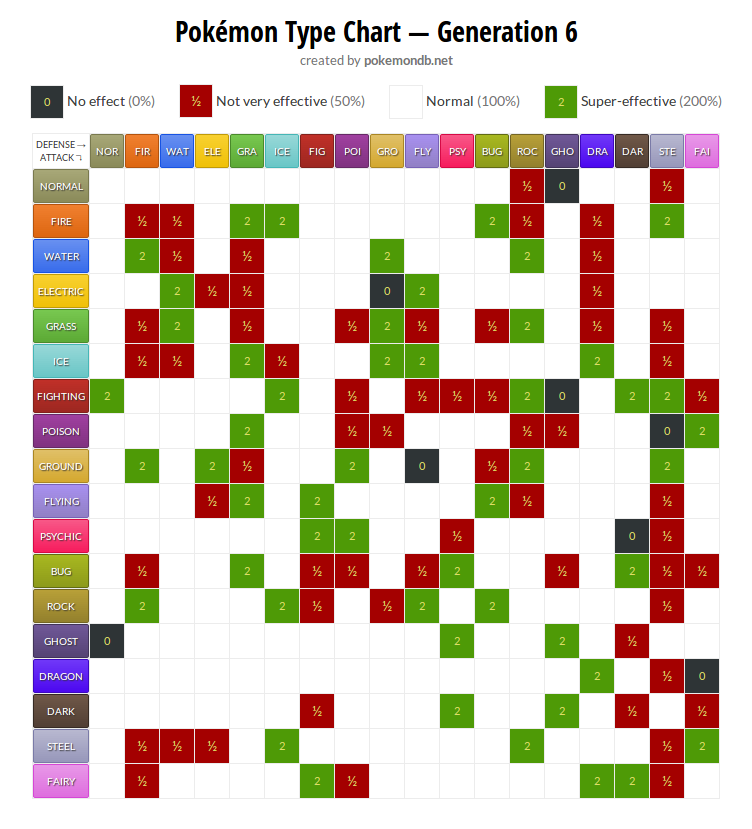

In [13]:
from IPython.display import Image
Image("typechart.png")

### I love open source (Type Chart Matrix from: https://github.com/zonination/pokemon-chart/blob/master/chart.csv )

In [14]:
#Fix typechart dataframe for my needs
typechart = pd.read_csv("chart.csv")

typechart['No Type'] = 1.0
typechart['Normal'] = typechart.Normal.astype('float64')

#add row for no type (why did it take me 15 mins to figure this out when it was this easy)
row = np.ones(19).tolist()
row.insert(0, "No Type")
typechart.loc[len(typechart)] = row

Calculations: (attack or sp.atk) * (1x2 effectivity matrix) for both pokemon <br>
Model: Typechart will only affect attack stat of each pokemon and not attack and defense for first pokemon<br>
Rationale: Matrix is not symmetric <br>
Ex. Fighting does 2x damage against Normal, but Normal does not do 0.5x damage to Fighting

In [15]:
#Drop bst because it has to be recalculated and redundant columns
try:
    train.drop("first_bst", axis=1, inplace=True)
    train.drop("second_bst", axis=1, inplace=True)
    train.drop("first_#", axis=1, inplace=True)
    train.drop("second_#", axis=1, inplace=True)
    train.drop("Winner", axis=1, inplace=True)
except Exception as e:
    print("Column already deleted")

In [16]:
train.head()

,second_Type 1,second_Type 2,second_HP,second_Attack,second_Defense,second_Sp. Atk,second_Sp. Def,second_Speed,first_Type 1,first_Type 2,first_HP,first_Attack,first_Defense,first_Sp. Atk,first_Sp. Def,first_Speed,First_pokemon,Second_pokemon,outcome
0,Grass,Poison,45,49,49,65,65,45,Normal,Flying,40,45,40,35,35,56,21,1,0
1,Grass,Poison,45,49,49,65,65,45,Normal,No Type,30,56,35,25,35,72,25,1,0
2,Grass,Poison,45,49,49,65,65,45,Grass,Poison,60,65,70,85,75,40,50,1,1
3,Grass,Poison,45,49,49,65,65,45,Fire,No Type,55,70,45,70,50,60,64,1,0
4,Grass,Poison,45,49,49,65,65,45,Grass,Poison,50,75,35,70,30,40,76,1,1


### Figure out how to optimize this 
In an effort to squash the influence speed has on the dataset, and make it easier to train, I changed the features from first stats and second stats to just the difference between each stat. If stat difference is < 0, then that means the first pokemon has an advantage in that stat. If the stat difference is > 0, then the second pokemon has an advantage in that stat. Ultimately, speed was squashed, but not enough. Model f1 score was slightly improved, and permutation importance is faster because there are less columns, so it's good to keep.

In [17]:
#Multiply atk and sp atk by the specified values in the typechart
train['first_Multiplier'] = 1.0
train['second_Multiplier'] = 1.0

train['type_interaction'] = 0.0

for idx, _ in tqdm(enumerate(train.iterrows())):
    first_multiplier = typechart.loc[(typechart.Attacking == train.iloc[idx]["first_Type 1"]) | (typechart.Attacking == train.iloc[idx]["first_Type 2"])][train.iloc[idx]["second_Type 1"]].prod() * typechart.loc[(typechart.Attacking == train.iloc[idx]["first_Type 1"]) | (typechart.Attacking == train.iloc[idx]["first_Type 2"])][train.iloc[idx]["second_Type 2"]].prod()
    second_multiplier = typechart.loc[(typechart.Attacking == train.iloc[idx]["second_Type 1"]) | (typechart.Attacking == train.iloc[idx]["second_Type 2"])][train.iloc[idx]["first_Type 1"]].prod() * typechart.loc[(typechart.Attacking == train.iloc[idx]["second_Type 1"]) | (typechart.Attacking == train.iloc[idx]["second_Type 2"])][train.iloc[idx]["first_Type 2"]].prod()
    
    train.at[idx, 'first_Multiplier'] = first_multiplier
    train.at[idx, 'second_Multiplier'] = second_multiplier

    train.at[idx, 'type_interaction'] = second_multiplier - first_multiplier
        
    train.at[idx, 'first_Attack'] = train.iloc[idx].first_Attack * first_multiplier
    train.at[idx, 'first_Sp. Atk'] = train.iloc[idx]['first_Sp. Atk'] * first_multiplier
    
    train.at[idx, 'second_Attack'] = train.iloc[idx].second_Attack * second_multiplier
    train.at[idx, 'second_Sp. Atk'] = train.iloc[idx]['second_Sp. Atk'] * second_multiplier

train['calc_speed'] = train['second_Speed'] - train['first_Speed'] 
train['calc_atk'] = train['second_Attack'] - train['first_Attack']
train['calc_def'] = train['second_Defense'] - train['first_Defense']
train['calc_spatk'] = train['second_Sp. Atk'] - train['first_Sp. Atk']
train['calc_spdef'] = train['second_Sp. Def'] - train['first_Sp. Def']

50000it [06:17, 132.50it/s]


In [18]:
train

,second_Type 1,second_Type 2,second_HP,second_Attack,second_Defense,second_Sp. Atk,second_Sp. Def,second_Speed,first_Type 1,first_Type 2,...,Second_pokemon,outcome,first_Multiplier,second_Multiplier,type_interaction,calc_speed,calc_atk,calc_def,calc_spatk,calc_spdef
0,Grass,Poison,45,24,49,32,65,45,Normal,Flying,...,1,0,2.00,0.50,-1.50,-11,-66,9,-38,30
1,Grass,Poison,45,49,49,65,65,45,Normal,No Type,...,1,0,1.00,1.00,0.00,-27,-7,14,40,30
2,Grass,Poison,45,12,49,16,65,45,Grass,Poison,...,1,1,0.25,0.25,0.00,5,-4,-21,-5,-10
3,Grass,Poison,45,24,49,32,65,45,Fire,No Type,...,1,0,2.00,0.50,-1.50,-15,-116,4,-108,15
4,Grass,Poison,45,12,49,16,65,45,Grass,Poison,...,1,1,0.25,0.25,0.00,5,-6,14,-1,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Fire,Water,80,220,120,260,90,70,Bug,Flying,...,800,0,0.50,2.00,1.50,-19,194,70,215,40
49996,Fire,Water,80,27,120,32,90,70,Poison,Water,...,800,1,1.00,0.25,-0.75,40,-33,60,-28,30
49997,Fire,Water,80,27,120,32,90,70,Poison,Water,...,800,1,1.00,0.25,-0.75,40,-33,60,-28,30
49998,Fire,Water,80,27,120,32,90,70,Dragon,No Type,...,800,1,1.00,0.25,-0.75,10,-48,67,-51,-23


In [19]:
train.drop(list(train.filter(regex = 'first_')), axis = 1, inplace = True)
train.drop(list(train.filter(regex = 'second_')), axis = 1, inplace = True)

In [20]:
train

,First_pokemon,Second_pokemon,outcome,type_interaction,calc_speed,calc_atk,calc_def,calc_spatk,calc_spdef
0,21,1,0,-1.50,-11,-66,9,-38,30
1,25,1,0,0.00,-27,-7,14,40,30
2,50,1,1,0.00,5,-4,-21,-5,-10
3,64,1,0,-1.50,-15,-116,4,-108,15
4,76,1,1,0.00,5,-6,14,-1,35
...,...,...,...,...,...,...,...,...,...
49995,735,800,0,1.50,-19,194,70,215,40
49996,761,800,1,-0.75,40,-33,60,-28,30
49997,761,800,1,-0.75,40,-33,60,-28,30
49998,776,800,1,-0.75,10,-48,67,-51,-23


In [21]:
train.calc_speed.describe()

count    50000.000000
mean         0.064800
std         41.340773
min       -165.000000
25%        -29.000000
50%          0.000000
75%         29.000000
max        170.000000
Name: calc_speed, dtype: float64

In [22]:
#idk how to make this work 

#train.iloc[0].first_Attack * typechart.loc[(typechart.Attacking == train.iloc[0]["first_Type 1"]) | (typechart.Attacking == train.iloc[0]["first_Type 2"])][train.iloc[0]["second_Type 1"]].prod()
# def calc_atk(battle):
#     battle = pd.Series(battle)
#     new_atk = (battle.first_Attack * typechart.loc[(typechart.Attacking == battle["first_Type 1"]) | (typechart.Attacking == battle["first_Type 2"])][battle["second_Type 1"]].prod() * typechart.loc[(typechart.Attacking == battle["first_Type 1"]) | (typechart.Attacking == battle["first_Type 2"])][battle["second_Type 2"]].prod()) 
#     return new_atk

### New problem: The dataset is imbalanced when it comes to type effectiveness
After running experiments on the training dataset, CV had an f1-score of 95% for randomforest. When running tests, the model performs very well when there is no type effectivity (Eevee vs. Ekans, Pikachu vs. Raichu), but surprisingly poorly when type is involved (Blastoise vs. Charizard). This means that the model is biased toward speed, and the threshold for when to prioritize modified attack over speed is really high. Looking at the data, it makes sense why type effectiveness isn't prominent. Below are the distributions of battles where pokemon 1 is effective against pokemon 2, but slower than pokemon 2, and vice-versa. The distributions are unusually even. So at training, using type as a node won't make the tree pure.

In [23]:
train[(train.type_interaction < 0) & (train.calc_speed > 0)].outcome.value_counts(normalize=True)

1    0.900028
0    0.099972
Name: outcome, dtype: float64

In [24]:
train[(train.type_interaction > 0)].outcome.value_counts()

1    8554
0    6266
Name: outcome, dtype: int64

In [25]:
train[(train.type_interaction > 0) & (train.calc_speed < 0)].outcome.value_counts(normalize=True)

0    0.865842
1    0.134158
Name: outcome, dtype: float64

In [26]:
train[(train.type_interaction > 0)].outcome.value_counts()

1    8554
0    6266
Name: outcome, dtype: int64

### Idea: Resample
Resample with replacement so that there are more cases of pokemon who are more effective but slower winning. Hopefully this works. <br>
Rate: A slower but more effective pokemon should beat its opponent 66% of the time. The rate was made by me and my friend by looking at the intuitive outcomes in charmander evolution line vs squirtle evolution line. 

In [27]:
from sklearn.utils import resample

In [28]:
train[(train.type_interaction < 0) & (train.calc_speed > 0)].outcome.value_counts()

1    6374
0     708
Name: outcome, dtype: int64

In [29]:
#Resample for first_pokemon
to_sample = train[(train.type_interaction < 0) & (train.calc_speed > 0) & (train.outcome == 0)]
n_samples = train[(train.type_interaction < 0) & (train.calc_speed > 0) & (train.outcome == 1)].shape[0]
first_sample = resample(to_sample, replace=True, n_samples=2*n_samples, random_state=42)
train = pd.concat([train, first_sample])

In [30]:
#Resample for second_pokemon
to_sample = train[(train.type_interaction > 0) & (train.calc_speed < 0) & (train.outcome == 1)]
n_samples = train[(train.type_interaction > 0) & (train.calc_speed < 0) & (train.outcome == 0)].shape[0]
second_sample = resample(to_sample, replace=True, n_samples=2*n_samples, random_state=42)
train = pd.concat([train, second_sample])

In [31]:
train.shape[0]

75062

In [32]:
train[(train.calc_speed < 0)].outcome.value_counts(normalize=True)

0    0.61343
1    0.38657
Name: outcome, dtype: float64

In [33]:
train[(train.calc_speed > 0)].outcome.value_counts(normalize=True)

1    0.626058
0    0.373942
Name: outcome, dtype: float64

In [34]:
train[(train.type_interaction < 0) & (train.calc_speed > 0)].outcome.value_counts()

0    13456
1     6374
Name: outcome, dtype: int64

### Note on speed, and data
Even after resampling (even going as far as 5 times instead of 2 times), the model wasn't able to catch that type interaction is more important than speed. As far as I'm concerned, it doesn't seem like there were any errors in model tuning. My guess is that there isn't enough data in the set that reflects pokemon winning purely via type advantage. This makes it weird, because my model performs really well on battles between pokemon with no type advantage, but surprisingly poorly on pokemon that have type advantages. 

In [35]:
#Save and pray that model training for this dataset isn't as hard as preprocessing it
#I hope to god the outcomes weren't arbitrarily made
train.to_csv("battles_updated.csv", index=False)